## Instructions

Run the first 2 cells, this stores heights vs. ARS names, heights are recorded at the location of known ARS locations (from ORIdb) 

Save this to a csv file. 

Plot heights for two different files

# Loop over chromosomes: Record all heights and report measurable widths

In [1]:
# imports

%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import convolve
import peakutils

In [2]:

# get oridb files to get locations of ars's
oriDB_df = pd.read_csv('oriDB_confirmed_ARSs.bed',  
                 names=['chromosome','start','stop','ars_name'], 
                 delim_whitespace=True, 
                 skiprows=2)


# Read bed file into a pandas "data frame"
#df = pd.read_csv('G.pileup.bed',  
df = pd.read_csv('bedfiles/Pd5-E_S5_R1_001_Mrc1_YS3285_exp_1.pileup.bed',  

#df = pd.read_csv('bedfiles/Pd7-G_S7_R1_001_Orc4_WT_exp_1.pileup.bed',          # WT exp 1
#df = pd.read_csv('bedfiles/Pd7-G_S7_R1_001_Orc4_WT_exp_2.pileup.bed',         # WT exp 2
                                   
#df = pd.read_csv('bedfiles/Pd8-H_S8_R1_001_Orc4_Exp_1_M5_N489A.pileup.bed',          # N489A  Exp - 1                                 
#df = pd.read_csv('bedfiles/Pd8-H_S8_R1_001_Orc4_Exp_2_M5_N489A.pileup.bed',          # N489A  Exp - 2                                                  

#df = pd.read_csv('bedfiles/Pd6-F_S6_R1_001.pileup.bed',       # F485Y_Y486F
#df = pd.read_csv('bedfiles/Pd11-K_S11_R1_001.pileup.bed',     # F485I_Y486Q
#df = pd.read_csv('bedfiles/Pd14-N_S14_R1_001.pileup.bed',     # N489W                 
#df = pd.read_csv('bedfiles/Pd12-L_S12_R1_001.pileup.bed',     # R478A                 
#df = pd.read_csv('bedfiles/Pd9-I_S9_R1_001.pileup.bed',                   # Y486Q                                  
#df = pd.read_csv('bedfiles/Pd5-E_S5_R1_001_F485A_y86A.pileup.bed',         # F485A_Y486A
#df = pd.read_csv('bedfiles/Pd10-J_S10_R1_001.pileup.bed',         # F485I
#df = pd.read_csv('bedfiles/Pd13-M_S13_R1_001.pileup.bed',         # R478k


                 names=['chromosome','start','stop','reads'], 
                 delim_whitespace=True, 
                 skiprows=2)


# lists to contain ars names and widths
ars_names_total = []
ars_widths_total = []
ars_heights_total = []

chrX_list = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7',
             'chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16']

chrom_we_want_list = ['chrI','chrII','chrIII','chrIV','chrV','chrVI','chrVII',
             'chrVIII','chrIX','chrX','chrXI','chrXII','chrXIII','chrXIV','chrXV','chrXVI']

kb = 1E3

# dictionaries which can be used for plotting each chromosome profile
# outside of this loop
smooth_reads_dict = {}
smooth_reads_xs_dict = {}
ars_names_dict = {}
ars_heights_dict = {}
ars_heights_xs_dict = {}
ars_widths_dict = {}
ars_widths_xs_dict = {}


### start loop here

for chromosome_index in range(len(chrX_list)):
#for chromosome_index in range(1):

    chrX_indices = oriDB_df['chromosome']==chrX_list[chromosome_index]    # loop index should go here
    chrom_we_want = chrom_we_want_list[chromosome_index]


    chr2_locations =(oriDB_df[chrX_indices]['start']/kb+oriDB_df[chrX_indices]['stop']/kb)/2.0
    chr2_names = oriDB_df[chrX_indices]['ars_name']

    # Extract values for current chromosome 
    indices = df.loc[:,'chromosome']==chrom_we_want
    chr2_df = df.loc[indices,:]

    # Compute read length
    read_length = df.loc[0,'stop'] - df.loc[0,'start'] + 1

    # Extract vectors of starts, stops, and number of reads
    starts = chr2_df.loc[:,'start'].values
    stops = chr2_df.loc[:,'stop'].values
    num_reads = chr2_df.loc[:,'reads'].astype(float).values


    ### smoothing

    # Create a "kernel" with which to smooth the data
    # from experience, 6 kb is a nice window size
    window_bp = 5000
    read_length = 51
    window_size = window_bp//read_length
    #print(window_size)
    # Create a window kernel so that all elements sum to 1
    window = np.ones(window_size)/window_size


    # Smooth the data by convolving (not convoluting!) the window with the read counts
    smooth_reads = convolve(num_reads,window,'same')
    # recording for plotting later (1)
    smooth_reads_dict[chrX_list[chromosome_index]] = smooth_reads

    #y = smooth_reads[zoom_indices]
    #max_y = max(y)  # Find the maximum y value
    #xs = [x for x in range(len(y)) if y[x] > max_y/2.0]


    ### get peaks
    #max_indices = peakutils.indexes(smooth_reads, thres=0.05, min_dist=1000)
    max_indices = peakutils.indexes(smooth_reads, thres=1E-3, min_dist=10)

    ### isolate peaks

    # this snippet needs to be vectorized...

    listbwd = []
    listfwd = []
    yMax = []

    for i in range(len(max_indices)):
        #print(indices[i])
        #print(smooth_reads[indices[i]])  # peak values

        #yMax = smooth_reads[max_indices[i]]
        yMax.append(smooth_reads[max_indices[i]])
        indexOfPeakFwd = max_indices[i]
        indexOfPeakBwd = max_indices[i]

        while smooth_reads[indexOfPeakFwd] > yMax[i]/2.0:

            if (indexOfPeakFwd+1) == len(starts):
                break
            indexOfPeakFwd+=1

        while smooth_reads[indexOfPeakBwd] > yMax[i]/2.0:

            if (indexOfPeakBwd-1) <= 0:
                break
            indexOfPeakBwd-=1

        listbwd.append(indexOfPeakBwd)
        listfwd.append(indexOfPeakFwd)

    chr2_locations =(oriDB_df[chrX_indices]['start']/kb+oriDB_df[chrX_indices]['stop']/kb)/2.0 


    ###  identify which peaks are ARS
    ars_locations = chr2_locations.values.ravel()
    peak_locations = starts[max_indices]/kb

    ### get indices of clean ARS-Peaks combos

    clean_peak_indices = []

    # get index of closest numer
    def closest(list, Number):
        aux = []
        for valor in list:
            aux.append(abs(Number-valor))

        return aux.index(min(aux))

    for ipeak in range(len(peak_locations)):
        #print(closest(ars_locations,peak_locations[ipeak]))
        clean_peak_indices.append(closest(ars_locations,peak_locations[ipeak]))


    ### record all ars heights
    x = 0.5*(starts+stops)/kb
    L = max(x)
    # recording for plotting later (2)
    smooth_reads_xs_dict[chrX_list[chromosome_index]] = x

    # index array of where ars's are locations
    indices_of_ars_locations = [] 

    # get index of closest numer
    def closest(list, Number):
        aux = []
        for valor in list:
            aux.append(abs(Number-valor))

        return aux.index(min(aux))

    for ith_ars_location in range(len(ars_locations)):    
        indices_of_ars_locations.append(closest(x,ars_locations[ith_ars_location]))
        

    # the heights of ars according to the smoothed profile    
    #smooth_reads[indices_of_ars_locations] 
    
    for append_index in range(len(chr2_names.tolist())):
        # record heights and names of the ars for the current chromosome
        ars_names_total.append(chr2_names.tolist()[append_index])
        ars_heights_total.append(smooth_reads[indices_of_ars_locations].tolist()[append_index])
    
    ars_names_dict[chrX_list[chromosome_index]] = chr2_names.tolist()
    ars_heights_dict[chrX_list[chromosome_index]] = smooth_reads[indices_of_ars_locations].tolist()
    ars_heights_xs_dict[chrX_list[chromosome_index]] = ars_locations
    
    # get widths from last cell of this file
    #ars_widths_dict[chrX_list[chromosome_index]] = 
    #ars_widths_xs_dict[chrX_list[chromosome_index]] = 
    
### store height results

# append the following three in a dataframe
#ars_locations    
#smooth_reads[indices_of_ars_locations]
# contains ars names
#chr2_names

# put everything in a dataframe
ars_height_df = pd.DataFrame(
    {'ARS': ars_names_total,
     'Heights': ars_heights_total
    })
    
    
### store width results

# widths
#ars_widths = [(x - y) for x, y in zip(starts[listfwd], starts[listbwd])]

# locations of ars, in kb
#ars_locs = ars_locations[clean_peak_indices].ravel().tolist()

# names of ars
#ars_names = chr2_names.values[clean_peak_indices].ravel().tolist()




In [71]:
#ars_height_df.to_csv('ORC4_WT_exp_1_heights.csv')
#ars_height_df.to_csv('ORC4_WT_exp_2_heights.csv')
#ars_height_df.to_csv('F485I_Y486Q.csv')
#ars_height_df.to_csv('N489W.csv')
#ars_height_df.to_csv('R478A.csv')
#ars_height_df.to_csv('Y486Q.csv')
#ars_height_df.to_csv('F485Y_Y486F.csv')
#ars_height_df.to_csv('F485A_Y486A.csv')
#ars_height_df.to_csv('F485I.csv')
#ars_height_df.to_csv('R478K.csv')
#ars_height_df.to_csv('Mrc1_heights.csv')
#


In [2]:
import pandas as pd
heights_MRC1 = pd.read_csv('Mrc1_heights.csv')

heights_ORC4_WT_exp1 = pd.read_csv('ORC4_WT_exp_1_heights.csv')
heights_ORC4_WT_exp2 = pd.read_csv('ORC4_WT_exp_2_heights.csv')

heights_N489A_exp_1 = pd.read_csv('N489A_exp_1.csv')
heights_N489A_exp_2 = pd.read_csv('N489A_exp_2.csv')

# exp 2 mutants
heights_F485I_Y486Q = pd.read_csv('F485I_Y486Q.csv')
heights_N489W = pd.read_csv('N489W.csv')
heights_R478A = pd.read_csv('R478A.csv')
heights_Y486Q = pd.read_csv('Y486Q.csv')
heights_F485Y_Y486F = pd.read_csv('F485Y_Y486F.csv')
heights_F485A_Y486A = pd.read_csv('F485A_Y486A.csv')
heights_F485I = pd.read_csv('F485I.csv')
heights_R478K = pd.read_csv('R478K.csv')



In [3]:
heights_ORC4_WT_exp1.head()

,Unnamed: 0,ARS,Heights
0,0,ARS102,1.285714
1,1,ARS102.5,0.418367
2,2,ARS103,0.367347
3,3,ARS104,3.102041
4,4,ARS105,0.908163


In [4]:
heights_ORC4_WT_exp1.head()

,Unnamed: 0,ARS,Heights
0,0,ARS102,1.285714
1,1,ARS102.5,0.418367
2,2,ARS103,0.367347
3,3,ARS104,3.102041
4,4,ARS105,0.908163


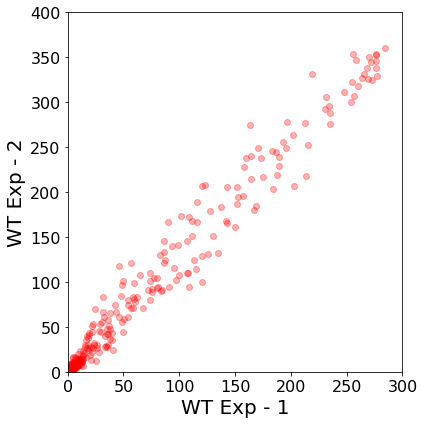

In [5]:
plt.figure(figsize=[6,6])
plt.plot(heights_ORC4_WT_exp1['Heights'], heights_ORC4_WT_exp2['Heights'],'ro',alpha=.3)
plt.xlim(0,300)
plt.ylim(0,400)
plt.ylabel('WT Exp - 2',fontsize=20)
plt.xlabel('WT Exp - 1',fontsize=20)
plt.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('WT_exp_1_vs_WT_exp_2.pdf')
plt.show()


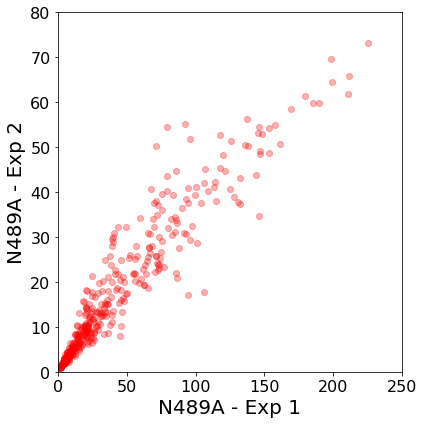

In [6]:
plt.figure(figsize=[6,6])
plt.plot(heights_N489A_exp_1['Heights'], heights_N489A_exp_2['Heights'],'ro',alpha=.3)
plt.xlim(0,250)
plt.ylim(0,80)
plt.ylabel('N489A - Exp 2',fontsize=20)
plt.xlabel('N489A - Exp 1',fontsize=20)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('N489A_exp_1_vs_N489A_exp_2.pdf')
plt.show()

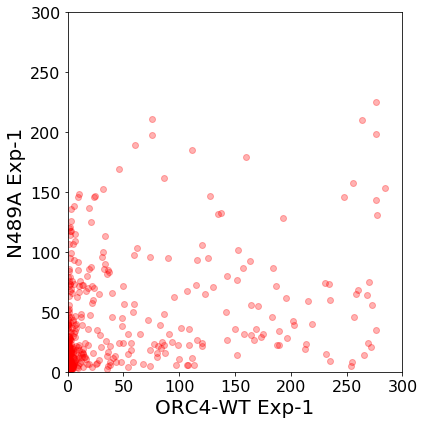

In [7]:
plt.figure(figsize=[6,6])
plt.plot(heights_ORC4_WT_exp1['Heights'], heights_N489A_exp_1['Heights'],'ro',alpha=.3)
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel('ORC4-WT Exp-1',fontsize=20)
plt.ylabel('N489A Exp-1',fontsize=20)
plt.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('N489A_vs_WT.pdf')
plt.show()

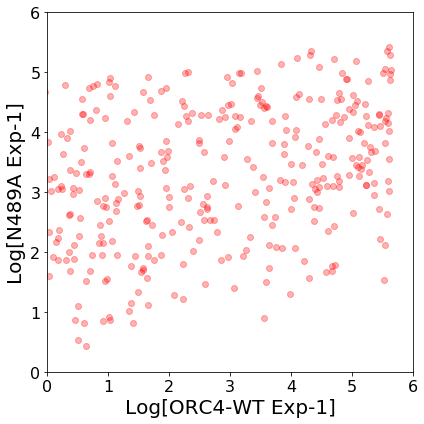

In [8]:
plt.figure(figsize=[6,6])
plt.plot(np.log(heights_ORC4_WT_exp1['Heights']), np.log(heights_N489A_exp_1['Heights']),'ro',alpha=.3)
plt.xlim(0,6)
plt.ylim(0,6)
plt.xlabel('Log[ORC4-WT Exp-1]',fontsize=20)
plt.ylabel('Log[N489A Exp-1]',fontsize=20)
plt.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('N489A_vs_WT_Log.pdf')
plt.show()

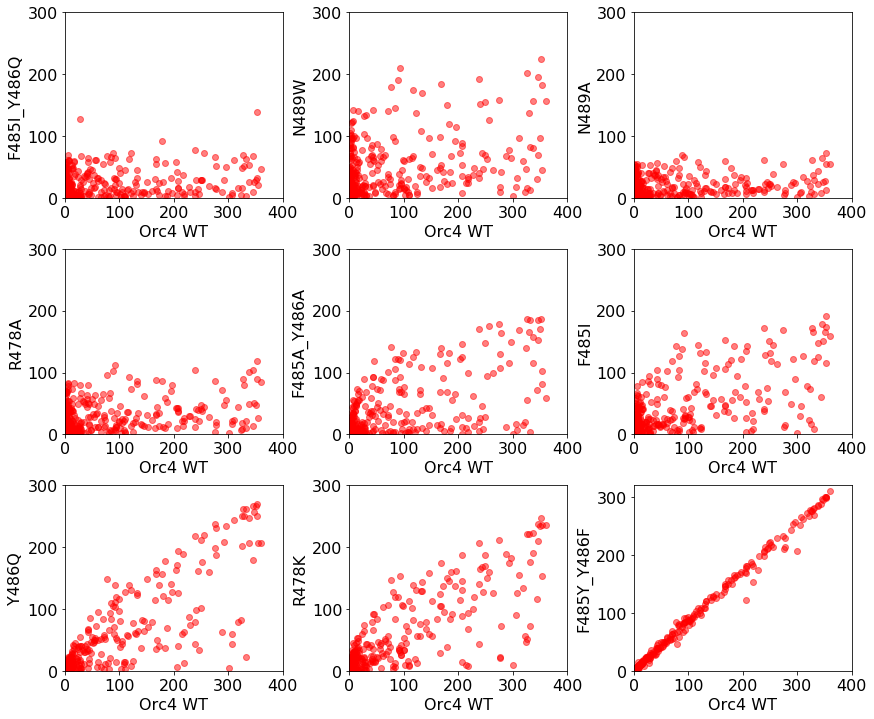

In [9]:

f, axarr = plt.subplots(3, 3,figsize=(12,10))


axarr[0, 0].plot(heights_ORC4_WT_exp2['Heights'], heights_F485I_Y486Q['Heights'],'ro',alpha=0.5)

axarr[0, 0].set_xlim([0,400])
axarr[0, 0].set_ylim([0,300])

axarr[0, 0].set_ylabel('F485I_Y486Q',fontsize=16)
axarr[0, 0].set_xlabel('Orc4 WT',fontsize=16)
#axarr[0, 0].set_title('Axis [0,0]')

axarr[0, 1].scatter(heights_ORC4_WT_exp2['Heights'], heights_N489W['Heights'],c='r',alpha=0.5)

axarr[0, 1].set_xlim([0,400])
axarr[0, 1].set_ylim([0,300])

axarr[0, 1].set_ylabel('N489W',fontsize=16)
axarr[0, 1].set_xlabel('Orc4 WT',fontsize=16)

axarr[0, 2].scatter(heights_ORC4_WT_exp2['Heights'], heights_N489A_exp_2['Heights'],c='r',alpha=0.5)

axarr[0, 2].set_xlim([0,400])
axarr[0, 2].set_ylim([0,300])

axarr[0, 2].set_ylabel('N489A',fontsize=16)
axarr[0, 2].set_xlabel('Orc4 WT',fontsize=16)



axarr[1, 0].scatter(heights_ORC4_WT_exp2['Heights'], heights_R478A['Heights'],c='r',alpha=0.5)

axarr[1, 0].set_xlim([0,400])
axarr[1, 0].set_ylim([0,300])

axarr[1, 0].set_ylabel('R478A',fontsize=16)
axarr[1, 0].set_xlabel('Orc4 WT',fontsize=16)

axarr[1, 1].scatter(heights_ORC4_WT_exp2['Heights'], heights_F485A_Y486A['Heights'],c='r',alpha=0.5)

axarr[1, 1].set_xlim([0,400])
axarr[1, 1].set_ylim([0,300])

axarr[1, 1].set_ylabel('F485A_Y486A',fontsize=16)
axarr[1, 1].set_xlabel('Orc4 WT',fontsize=16)

axarr[1, 2].scatter(heights_ORC4_WT_exp2['Heights'], heights_F485I['Heights'],c='r',alpha=0.5)

axarr[1, 2].set_xlim([0,400])
axarr[1, 2].set_ylim([0,300])

axarr[1, 2].set_ylabel('F485I',fontsize=16)
axarr[1, 2].set_xlabel('Orc4 WT',fontsize=16)



axarr[2, 0].scatter(heights_ORC4_WT_exp2['Heights'], heights_Y486Q['Heights'],c='r',alpha=0.5)

axarr[2, 0].set_xlim([0,400])
axarr[2, 0].set_ylim([0,300])

axarr[2, 0].set_ylabel('Y486Q',fontsize=16)
axarr[2, 0].set_xlabel('Orc4 WT',fontsize=16)


axarr[2, 1].scatter(heights_ORC4_WT_exp2['Heights'], heights_R478K['Heights'],c='r',alpha=0.5)

axarr[2, 1].set_xlim([0,400])
axarr[2, 1].set_ylim([0,300])

axarr[2, 1].set_ylabel('R478K',fontsize=16)
axarr[2, 1].set_xlabel('Orc4 WT',fontsize=16)



axarr[2, 2].scatter(heights_ORC4_WT_exp2['Heights'], heights_F485Y_Y486F['Heights'],c='r',alpha=0.5)

axarr[2, 2].set_xlim([0,400])
axarr[2, 2].set_ylim([0,320])

axarr[2, 2].set_ylabel('F485Y_Y486F',fontsize=16)
axarr[2, 2].set_xlabel('Orc4 WT',fontsize=16)





#axarr[0, 1].set_title('Axis [0,1]')

#axarr[1, 0].plot(x, y,'ro')
#axarr[1, 0].set_title('Axis [1,0]')
#axarr[1, 1].scatter(x, y)
#axarr[1, 1].set_title('Axis [1,1]')


plt.tight_layout()
for ax in axarr.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')
    ax.tick_params(axis='both', which='major', labelsize=16)

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axarr.flat:
#    ax.label_outer()
plt.savefig('Exp_2_Mutants_vs_WT_heights.pdf')

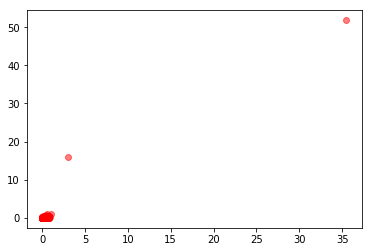

In [16]:
#tmp_df['heights'] /= np.percentile(tmp_df['heights'],99.5)
#plt.plot(heights_MRC1['Heights'], heights_F485I_Y486Q['Heights'],'ro',alpha=0.5)
#plt.show()
plt.plot(heights_MRC1['Heights'].values/np.percentile(heights_MRC1['Heights'],99.5),heights_F485I_Y486Q['Heights']/np.percentile(heights_F485I_Y486Q['Heights'],99.5),'ro',alpha=0.5)

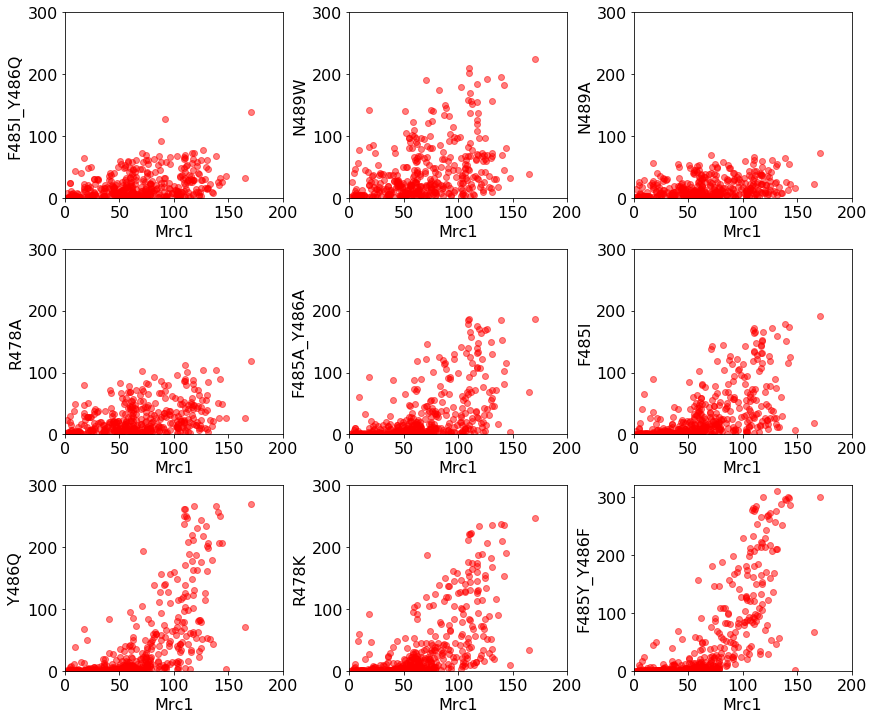

In [10]:

f, axarr = plt.subplots(3, 3,figsize=(12,10))


axarr[0, 0].plot(heights_MRC1['Heights'], heights_F485I_Y486Q['Heights'],'ro',alpha=0.5)

axarr[0, 0].set_xlim([0,200])
axarr[0, 0].set_ylim([0,300])

axarr[0, 0].set_ylabel('F485I_Y486Q',fontsize=16)
axarr[0, 0].set_xlabel('Mrc1',fontsize=16)
#axarr[0, 0].set_title('Axis [0,0]')

axarr[0, 1].scatter(heights_MRC1['Heights'], heights_N489W['Heights'],c='r',alpha=0.5)

axarr[0, 1].set_xlim([0,200])
axarr[0, 1].set_ylim([0,300])

axarr[0, 1].set_ylabel('N489W',fontsize=16)
axarr[0, 1].set_xlabel('Mrc1',fontsize=16)

axarr[0, 2].scatter(heights_MRC1['Heights'], heights_N489A_exp_2['Heights'],c='r',alpha=0.5)

axarr[0, 2].set_xlim([0,200])
axarr[0, 2].set_ylim([0,300])

axarr[0, 2].set_ylabel('N489A',fontsize=16)
axarr[0, 2].set_xlabel('Mrc1',fontsize=16)



axarr[1, 0].scatter(heights_MRC1['Heights'], heights_R478A['Heights'],c='r',alpha=0.5)

axarr[1, 0].set_xlim([0,200])
axarr[1, 0].set_ylim([0,300])

axarr[1, 0].set_ylabel('R478A',fontsize=16)
axarr[1, 0].set_xlabel('Mrc1',fontsize=16)

axarr[1, 1].scatter(heights_MRC1['Heights'], heights_F485A_Y486A['Heights'],c='r',alpha=0.5)

axarr[1, 1].set_xlim([0,200])
axarr[1, 1].set_ylim([0,300])

axarr[1, 1].set_ylabel('F485A_Y486A',fontsize=16)
axarr[1, 1].set_xlabel('Mrc1',fontsize=16)

axarr[1, 2].scatter(heights_MRC1['Heights'], heights_F485I['Heights'],c='r',alpha=0.5)

axarr[1, 2].set_xlim([0,200])
axarr[1, 2].set_ylim([0,300])

axarr[1, 2].set_ylabel('F485I',fontsize=16)
axarr[1, 2].set_xlabel('Mrc1',fontsize=16)



axarr[2, 0].scatter(heights_MRC1['Heights'], heights_Y486Q['Heights'],c='r',alpha=0.5)

axarr[2, 0].set_xlim([0,200])
axarr[2, 0].set_ylim([0,300])

axarr[2, 0].set_ylabel('Y486Q',fontsize=16)
axarr[2, 0].set_xlabel('Mrc1',fontsize=16)


axarr[2, 1].scatter(heights_MRC1['Heights'], heights_R478K['Heights'],c='r',alpha=0.5)

axarr[2, 1].set_xlim([0,200])
axarr[2, 1].set_ylim([0,300])

axarr[2, 1].set_ylabel('R478K',fontsize=16)
axarr[2, 1].set_xlabel('Mrc1',fontsize=16)



axarr[2, 2].scatter(heights_MRC1['Heights'], heights_F485Y_Y486F['Heights'],c='r',alpha=0.5)

axarr[2, 2].set_xlim([0,200])
axarr[2, 2].set_ylim([0,320])

axarr[2, 2].set_ylabel('F485Y_Y486F',fontsize=16)
axarr[2, 2].set_xlabel('Mrc1',fontsize=16)





#axarr[0, 1].set_title('Axis [0,1]')

#axarr[1, 0].plot(x, y,'ro')
#axarr[1, 0].set_title('Axis [1,0]')
#axarr[1, 1].scatter(x, y)
#axarr[1, 1].set_title('Axis [1,1]')


plt.tight_layout()
for ax in axarr.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')
    ax.tick_params(axis='both', which='major', labelsize=16)

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axarr.flat:
#    ax.label_outer()
#plt.savefig('Exp_2_Mutants_vs_MRC1_heights.pdf')

In [ ]:

f, axarr = plt.subplots(3, 3,figsize=(12,10))


axarr[0, 0].plot(heights_MRC1['Heights'], heights_F485I_Y486Q['Heights'],'ro',alpha=0.5)

axarr[0, 0].set_xlim([0,200])
axarr[0, 0].set_ylim([0,300])

axarr[0, 0].set_ylabel('F485I_Y486Q',fontsize=16)
axarr[0, 0].set_xlabel('Mrc1',fontsize=16)
#axarr[0, 0].set_title('Axis [0,0]')

axarr[0, 1].scatter(heights_MRC1['Heights'], heights_N489W['Heights'],c='r',alpha=0.5)

axarr[0, 1].set_xlim([0,200])
axarr[0, 1].set_ylim([0,300])

axarr[0, 1].set_ylabel('N489W',fontsize=16)
axarr[0, 1].set_xlabel('Mrc1',fontsize=16)

axarr[0, 2].scatter(heights_MRC1['Heights'], heights_N489A_exp_2['Heights'],c='r',alpha=0.5)

axarr[0, 2].set_xlim([0,200])
axarr[0, 2].set_ylim([0,300])

axarr[0, 2].set_ylabel('N489A',fontsize=16)
axarr[0, 2].set_xlabel('Mrc1',fontsize=16)



axarr[1, 0].scatter(heights_MRC1['Heights'], heights_R478A['Heights'],c='r',alpha=0.5)

axarr[1, 0].set_xlim([0,200])
axarr[1, 0].set_ylim([0,300])

axarr[1, 0].set_ylabel('R478A',fontsize=16)
axarr[1, 0].set_xlabel('Mrc1',fontsize=16)

axarr[1, 1].scatter(heights_MRC1['Heights'], heights_F485A_Y486A['Heights'],c='r',alpha=0.5)

axarr[1, 1].set_xlim([0,200])
axarr[1, 1].set_ylim([0,300])

axarr[1, 1].set_ylabel('F485A_Y486A',fontsize=16)
axarr[1, 1].set_xlabel('Mrc1',fontsize=16)

axarr[1, 2].scatter(heights_MRC1['Heights'], heights_F485I['Heights'],c='r',alpha=0.5)

axarr[1, 2].set_xlim([0,200])
axarr[1, 2].set_ylim([0,300])

axarr[1, 2].set_ylabel('F485I',fontsize=16)
axarr[1, 2].set_xlabel('Mrc1',fontsize=16)



axarr[2, 0].scatter(heights_MRC1['Heights'], heights_Y486Q['Heights'],c='r',alpha=0.5)

axarr[2, 0].set_xlim([0,200])
axarr[2, 0].set_ylim([0,300])

axarr[2, 0].set_ylabel('Y486Q',fontsize=16)
axarr[2, 0].set_xlabel('Mrc1',fontsize=16)


axarr[2, 1].scatter(heights_MRC1['Heights'], heights_R478K['Heights'],c='r',alpha=0.5)

axarr[2, 1].set_xlim([0,200])
axarr[2, 1].set_ylim([0,300])

axarr[2, 1].set_ylabel('R478K',fontsize=16)
axarr[2, 1].set_xlabel('Mrc1',fontsize=16)



axarr[2, 2].scatter(heights_MRC1['Heights'], heights_F485Y_Y486F['Heights'],c='r',alpha=0.5)

axarr[2, 2].set_xlim([0,200])
axarr[2, 2].set_ylim([0,320])

axarr[2, 2].set_ylabel('F485Y_Y486F',fontsize=16)
axarr[2, 2].set_xlabel('Mrc1',fontsize=16)





#axarr[0, 1].set_title('Axis [0,1]')

#axarr[1, 0].plot(x, y,'ro')
#axarr[1, 0].set_title('Axis [1,0]')
#axarr[1, 1].scatter(x, y)
#axarr[1, 1].set_title('Axis [1,1]')


plt.tight_layout()
for ax in axarr.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')
    ax.tick_params(axis='both', which='major', labelsize=16)

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axarr.flat:
#    ax.label_outer()
#plt.savefig('Exp_2_Mutants_vs_MRC1_heights.pdf')

In [ ]:
WT_ys, WT_xs, Nieduszynski_df,WT_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd7-G_S7_R1_001.pileup.bed')
F485A_Y486A_ys, F485A_Y486A_xs, Nieduszynski_df,F485A_Y486_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd5-E_S5_R1_001.pileup.bed')
Mrc1_ys, Mrc1_xs, Nieduszynski_df,Mrc1_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd5-E_S5_R1_001_Mrc1_YS3285.pileup.bed')
N489A_ys, N489A_xs, Nieduszynski_df,N489A_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd8-H_S8_R1_001.pileup.bed')
Y486Q_ys, Y486Q_xs, Nieduszynski_df,Y486Q_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd9-I_S9_R1_001.pileup.bed')
F485I_ys, F485I_xs, Nieduszynski_df,F485I_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd10-J_S10_R1_001.pileup.bed')
F485I_Y486Q_ys, F485I_Y486Q_xs, Nieduszynski_df,F485I_Y486Q_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd11-K_S11_R1_001.pileup.bed')
R478A_ys, R478A_xs, Nieduszynski_df,R478A_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd12-L_S12_R1_001.pileup.bed')
R478K_ys, R478K_xs, Nieduszynski_df,R478K_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd13-M_S13_R1_001.pileup.bed')
N489W_ys, N489W_xs, Nieduszynski_df,N489W_peaks = get_smooth_reads(bed_file_name='bedfiles/Pd14-N_S14_R1_001.pileup.bed')

## Profile Plot

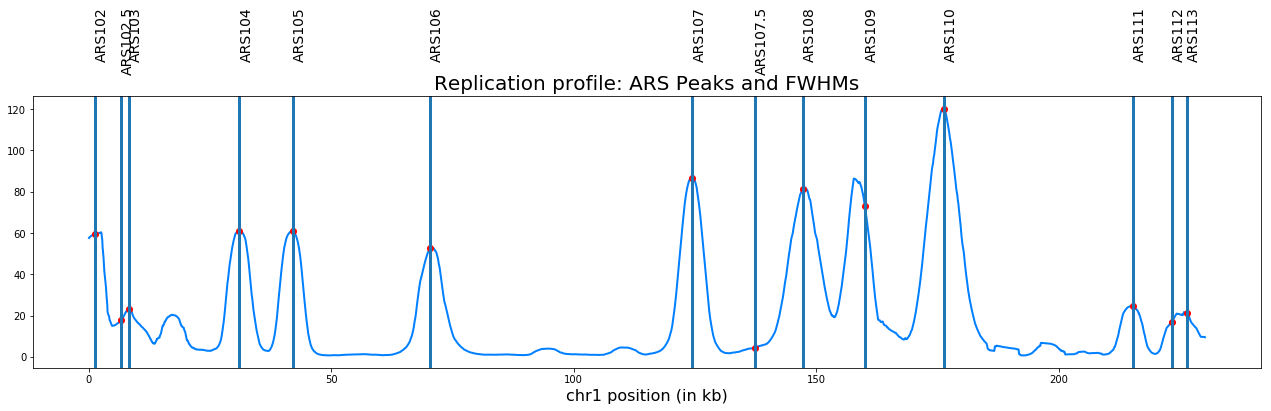

In [11]:
# specify chromosome and the following snippet with plot the smoothed profile
# verticle lines display ars's. 
# red dots indicate height of profile where ars is located according to oridb

chromosome_to_plot = 'chr1'
lightblue = [0, .5, 1]

figure_size = [22,5]
label_size = 16
title_size = 20
plt.figure(figsize=figure_size)



# Add some text annotation, telling the user
plt.title('Replication profile: ARS Peaks and FWHMs', fontsize=title_size)
plt.xlabel(chromosome_to_plot + ' position (in kb)', fontsize=label_size)


smooth_reads_dict[chromosome_to_plot]
xs = smooth_reads_xs_dict[chromosome_to_plot]
plt.plot(xs, smooth_reads_dict[chromosome_to_plot], color=lightblue, linewidth=2)
plt.plot(ars_heights_xs_dict[chromosome_to_plot], ars_heights_dict[chromosome_to_plot], 'ro')

for ars_name_index in range(len(ars_names_dict[chromosome_to_plot])):
    plt.axvline(x=ars_heights_xs_dict[chromosome_to_plot][ars_name_index],linewidth=3)
    plt.text(ars_heights_xs_dict[chromosome_to_plot][ars_name_index],plt.ylim()[1]*1.3,
              ars_names_dict[chromosome_to_plot][ars_name_index],rotation=90,size=14)





## Testing

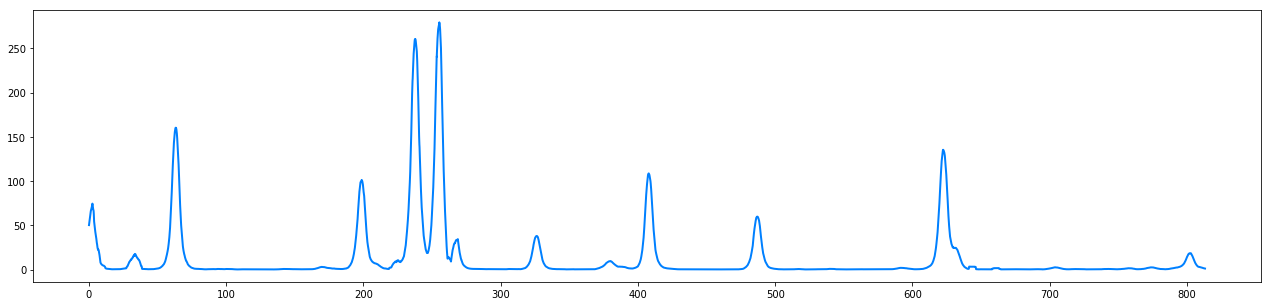

In [7]:
plt.figure(figsize=[22,5])
plt.plot(xs, smooth_reads_dict[chromosome_to_plot], color=lightblue, linewidth=2)

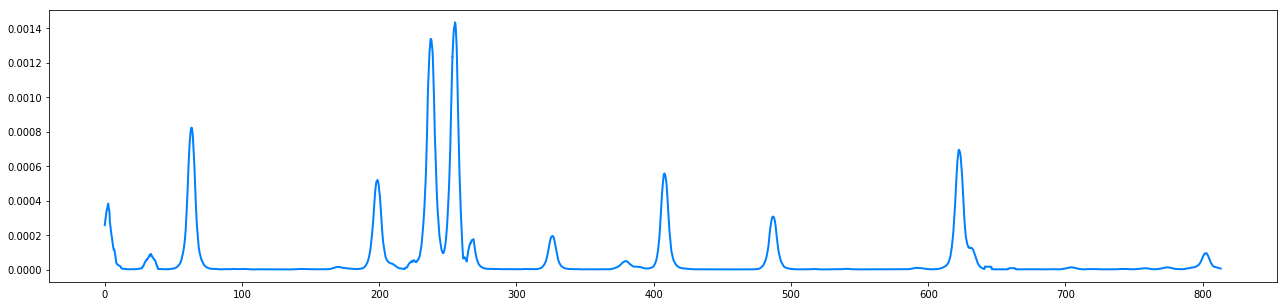

In [12]:
tempZ = np.sum(smooth_reads_dict[chromosome_to_plot])
tempNormSmoothReads = smooth_reads_dict[chromosome_to_plot]/tempZ
plt.figure(figsize=[22,5])
plt.plot(xs, tempNormSmoothReads, color=lightblue, linewidth=2)

## Quantile function Rescaling

In [3]:
# run as: max_height = quantile(heights,0.995)

def quantile(xs, p):
    assert(p <= 1)
    assert(p > 0);
    sorted_xs = np.sort(xs);
    N = len(xs);
    index = int(np.ceil(N*p))-1;
    x = sorted_xs[index];
    return x

Lambda = quantile(ars_heights_dict['chr7'],0.955)
#ars_heights_dict['chr7'] = ars_heights_dict['chr7']/Lambda

# Heights vs. heights scatter plots

In [4]:
heights_df = pd.read_csv('ARS_vs_Heights_3_samples.csv')

In [5]:
heights_df.head()

,ARS,Pd5-E_S5_R1_001_heights,Pd7-G_S7_R1_001_heights,Pd8-H_S8_R1_001_heights
0,ARS102,59.428571,1.285714,38.153061
1,ARS102.5,17.867347,0.418367,25.295918
2,ARS103,23.408163,0.367347,20.887755
3,ARS104,61.040816,3.102041,14.653061
4,ARS105,60.969388,0.908163,28.928571


In [6]:
Pd5_heights = heights_df['Pd5-E_S5_R1_001_heights']
Pd7_heights = heights_df['Pd7-G_S7_R1_001_heights']
Pd8_heights = heights_df['Pd8-H_S8_R1_001_heights']

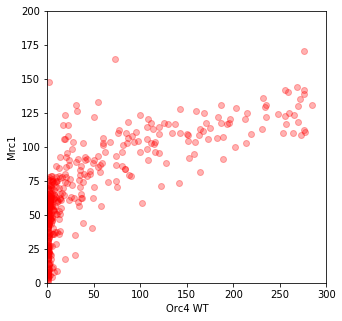

In [7]:
plt.figure(figsize=[5,5])
plt.plot(Pd7_heights, Pd5_heights,'ro',alpha=.3)
plt.xlim(0,300)
plt.ylim(0,200)
plt.ylabel('Mrc1')
plt.xlabel('Orc4 WT')
plt.show()

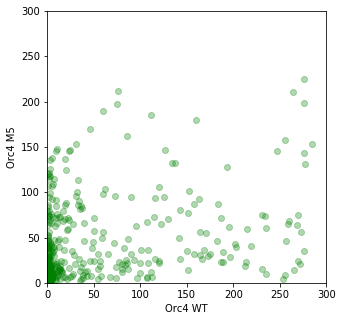

In [8]:
plt.figure(figsize=[5,5])
plt.plot(Pd7_heights, Pd8_heights,'go',alpha=.3)
plt.xlim(0,300)
plt.ylim(0,300)
plt.ylabel('Orc4 M5')
plt.xlabel('Orc4 WT')
plt.show()


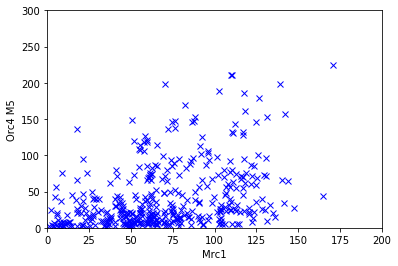

In [9]:
plt.plot(Pd5_heights, Pd8_heights,'bx')
plt.xlim(0,200)
plt.ylim(0,300)
plt.xlabel('Mrc1')
plt.ylabel('Orc4 M5')
plt.show()

## test plot with widths

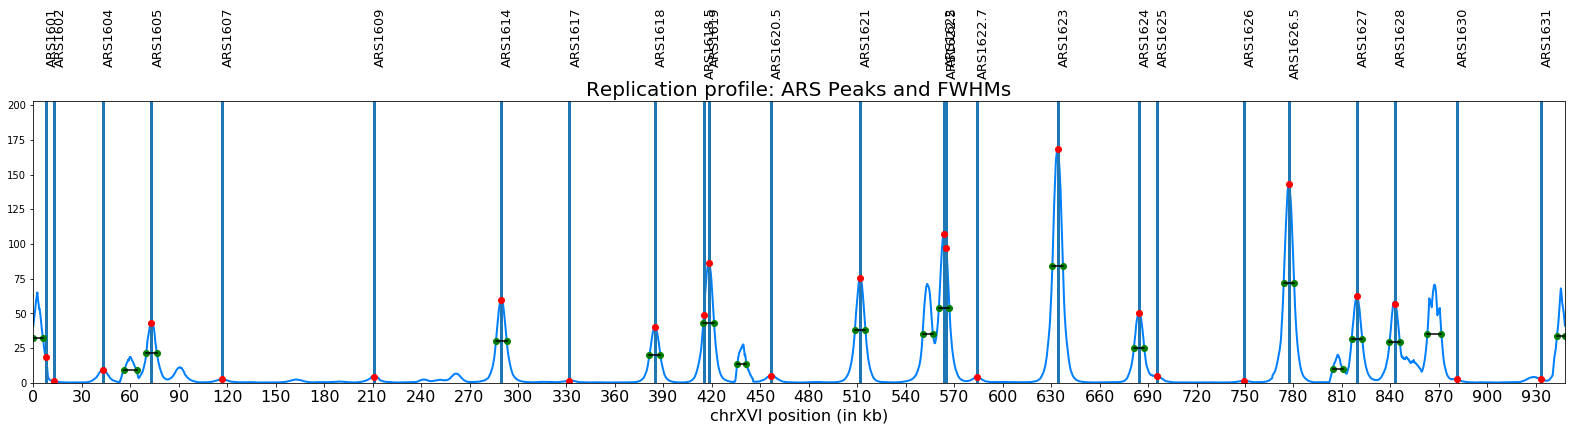

In [10]:
# Choose our color
lightblue = [0, .5, 1]

# Easier to discuss genomic positions in kb
kb = 1E3
x = 0.5*(starts+stops)/kb
L = max(x)

figure_size = [22,5]
label_size = 16
title_size = 20
plt.figure(figsize=figure_size)

# Add some text annotation, telling the user
plt.title('Replication profile: ARS Peaks and FWHMs', fontsize=title_size)
plt.xlabel(chrom_we_want + ' position (in kb)', fontsize=label_size)

# Fix spacing
plt.tight_layout()

# Place tick marks on x axis ever 200 kb
plt.xticks(np.arange(0,L,30), fontsize=label_size)

# Fit plot to precisely the width of the chromosome
plt.xlim([min(x), max(x)])

file_name = 'profile_for_%s.png'%chrom_we_want

# set ylim
plt.ylim(0,max(smooth_reads[max_indices])*1.2)


# Plot smoothed profile
plt.plot(x, smooth_reads, color=lightblue, linewidth=2)

label_index = 0;

ars_locations = chr2_locations.values.ravel()
for xc in ars_locations:
    plt.axvline(x=xc,linewidth=3)
    #plt.text(xc,plt.ylim()[1]+120,chr2_names.values[clean_peak_indices].ravel()[label_index],rotation=45,size=15)
    plt.text(xc,plt.ylim()[1]*1.3,chr2_names.values[label_index],rotation=90,size=13)
    label_index+=1
    

# mark FWHM with green dots
for index in range(len(listfwd)):
    plt.plot(starts[listbwd[index]]/kb,yMax[index]/2.0,'go')
    plt.plot(starts[listfwd[index]]/kb,yMax[index]/2.0,'go')
    plt.plot([starts[listbwd[index]]/kb,starts[listfwd[index]]/kb],[yMax[index]/2.0,yMax[index]/2.0],'k-')    
    
    
# plot ars from oridb as red dots
plt.plot(ars_locations,smooth_reads[indices_of_ars_locations],'ro')    
    
plt.show()

In [1]:
import os
os.getcwd()

'/Users/tareen/Desktop/bedfiles'